In [ ]:
!pip install opendatasets --upgrade --quiet
!pip install kaggle --quiet

# Import required libraries
import opendatasets as od
import os
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.models import Model
import tensorflow as tf
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
import time

# Download dataset from Kaggle
dataset_url = 'https://www.kaggle.com/datasets/nilesh789/eurosat-rgb'
od.download(dataset_url)

# Set the path to the image folder
data_path = '/content/eurosat-rgb/2750'

# Load and preprocess dataset
image_data = []
labels = []

for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".jpg"):
            image = cv2.imread(os.path.join(root, file))
            image = cv2.resize(image, (32, 32))
            image = img_to_array(image)
            image_data.append(image)
            label = root.split(os.path.sep)[-1]
            labels.append(label)

image_data = np.array(image_data, dtype="float") / 255.0
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

x_train, x_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=42)
print(f'Training samples: {len(x_train)}, Testing samples: {len(x_test)}')

# Define Teacher Model
def teacher_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

# Define Student Model
def student_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

input_shape = (32, 32, 3)
num_classes = len(lb.classes_)

teacher = teacher_model(input_shape, num_classes)
student = student_model(input_shape, num_classes)

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.1)) if epoch >= 10 else float(lr)

# Train Teacher
teacher.compile(optimizer=SGD(learning_rate=1e-2, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
teacher.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

# Teacher Evaluation
teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')

# Teacher predictions (for distillation)
teacher_preds = teacher.predict(x_train)

# Distillation Loss Function (alpha=0.25)
def distillation_loss(y_true, y_pred, teacher_preds, temperature=3.0, alpha=0.25):
    teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
    y_true_soft = tf.keras.activations.softmax(y_true / temperature)
    y_pred_soft = tf.keras.activations.softmax(y_pred / temperature)
    teacher_soft = tf.keras.activations.softmax(teacher_batch_preds / temperature)
    soft_loss = tf.keras.losses.categorical_crossentropy(teacher_soft, y_pred_soft)
    hard_loss = tf.keras.losses.categorical_crossentropy(y_true_soft, y_pred_soft)
    return alpha * soft_loss + (1. - alpha) * hard_loss

# Train Student
student.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds),
    metrics=['accuracy']
)
student.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

# Save trained models
teacher.save("teacher_model.h5")
student.save("student_model.h5")
print("Models saved successfully.")

# Evaluate Student on Clean Test Set
start_time = time.time()
y_pred_probs = student.predict(x_test)
inference_time = time.time() - start_time

y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n=== Final Student Model Evaluation on Clean Test Set ===")
print(classification_report(y_true, y_pred, target_names=lb.classes_))
print(f"Inference Time: {inference_time:.4f} seconds")

# -----------------------------
# Robustness Evaluation Against Gaussian Noise
# -----------------------------

y_reference_probs = student.predict(x_test)
y_reference = np.argmax(y_reference_probs, axis=1)

# Lists to store results
stddev_values = np.linspace(0, 1, 20)
noisy_accuracies, noisy_f1_scores, noisy_precisions, noisy_recalls = [], [], [], []
y_reference_list = []
y_reference_probs_list = []
y_pred_noisy_probs_list = []
y_pred_noisy_list = []

for stddev in stddev_values:
    noise = np.random.normal(loc=0.0, scale=stddev, size=x_test.shape)
    x_noisy = np.clip(x_test + noise, 0., 1.)

    y_pred_noisy_probs = student.predict(x_noisy)
    y_pred_noisy = np.argmax(y_pred_noisy_probs, axis=1)

    acc = accuracy_score(y_reference, y_pred_noisy)
    f1 = f1_score(y_reference, y_pred_noisy, average='weighted')
    precision = precision_score(y_reference, y_pred_noisy, average='weighted')
    recall = recall_score(y_reference, y_pred_noisy, average='weighted')

    noisy_accuracies.append(acc)
    noisy_f1_scores.append(f1)
    noisy_precisions.append(precision)
    noisy_recalls.append(recall)

    # Store predictions and references
    y_reference_list.append(y_reference)
    y_reference_probs_list.append(y_reference_probs)
    y_pred_noisy_probs_list.append(y_pred_noisy_probs)
    y_pred_noisy_list.append(y_pred_noisy)

    print(f"Noise STDDEV = {stddev:.2f} -> Accuracy = {acc:.4f}, F1 = {f1:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/nilesh789/eurosat-rgb


100%|██████████| 89.6M/89.6M [00:00<00:00, 1.17GB/s]

Training samples: 21600, Testing samples: 5400
Epoch 1/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 246s 362ms/step - accuracy: 0.2532 - loss: 1.9167 - val_accuracy: 0.5957 - val_loss: 1.1576 - learning_rate: 0.0100
Epoch 2/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 265s 367ms/step - accuracy: 0.5664 - loss: 1.1775 - val_accuracy: 0.6509 - val_loss: 0.9389 - learning_rate: 0.0100
Epoch 3/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 254s 355ms/step - accuracy: 0.6608 - loss: 0.9374 - val_accuracy: 0.7087 - val_loss: 0.8051 - learning_rate: 0.0100
Epoch 4/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 240s 355ms/step - accuracy: 0.7176 - loss: 0.7924 - val_accuracy: 0.7798 - val_loss: 0.6186 - learning_rate: 0.0100
Epoch 5/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 247s 365ms/step - accuracy: 0.7712 - loss: 0.6487 - val_accuracy: 0.7593 - val_loss: 0.6969 - learning_rate: 0.0100
Epoch 6/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 255s 355ms/step - accuracy: 0.7917 - loss: 0.5829 - val_accuracy: 0.7644 - val_loss: 0.6802 - learning_rate: 0.0100
Epoch 7/15
675/67

Models saved successfully.
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step

=== Final Student Model Evaluation on Clean Test Set ===
                      precision    recall  f1-score   support

          AnnualCrop       0.87      0.87      0.87       576
              Forest       0.96      0.97      0.97       606
HerbaceousVegetation       0.85      0.84      0.84       614
             Highway       0.75      0.81      0.78       482
          Industrial       0.91      0.93      0.92       490
             Pasture       0.84      0.85      0.84       425
       PermanentCrop       0.81      0.70      0.75       514
         Residential       0.93      0.96      0.95       579
               River       0.87      0.84      0.86       517
             SeaLake       0.97      0.98      0.97       597

            accuracy                           0.88      5400
           macro avg       0.88      0.88      0.88      5400
        weighted avg       0.88      0.88      0.88      5400

In

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.11 -> Accuracy = 0.2465, F1 = 0.1740, Precision = 0.3520, Recall = 0.2465
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.16 -> Accuracy = 0.2026, F1 = 0.1128, Precision = 0.2702, Recall = 0.2026
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.21 -> Accuracy = 0.1893, F1 = 0.0938, Precision = 0.0891, Recall = 0.1893
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
Noise STDDEV = 0.26 -> Accuracy = 0.1785, F1 = 0.0789, Precision = 0.0604, Recall = 0.1785


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.32 -> Accuracy = 0.1719, F1 = 0.0691, Precision = 0.0496, Recall = 0.1719
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.37 -> Accuracy = 0.1589, F1 = 0.0619, Precision = 0.0487, Recall = 0.1589
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step
Noise STDDEV = 0.42 -> Accuracy = 0.1494, F1 = 0.0549, Precision = 0.1336, Recall = 0.1494


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Noise STDDEV = 0.47 -> Accuracy = 0.1480, F1 = 0.0528, Precision = 0.0425, Recall = 0.1480


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step
Noise STDDEV = 0.53 -> Accuracy = 0.1357, F1 = 0.0470, Precision = 0.0331, Recall = 0.1357


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Noise STDDEV = 0.58 -> Accuracy = 0.1352, F1 = 0.0467, Precision = 0.0313, Recall = 0.1352


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.63 -> Accuracy = 0.1307, F1 = 0.0452, Precision = 0.0537, Recall = 0.1307
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step
Noise STDDEV = 0.68 -> Accuracy = 0.1272, F1 = 0.0433, Precision = 0.0261, Recall = 0.1272


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Noise STDDEV = 0.74 -> Accuracy = 0.1254, F1 = 0.0435, Precision = 0.0565, Recall = 0.1254


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step
Noise STDDEV = 0.79 -> Accuracy = 0.1215, F1 = 0.0413, Precision = 0.0249, Recall = 0.1215


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.84 -> Accuracy = 0.1233, F1 = 0.0428, Precision = 0.0475, Recall = 0.1233
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.89 -> Accuracy = 0.1187, F1 = 0.0403, Precision = 0.0243, Recall = 0.1187
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Noise STDDEV = 0.95 -> Accuracy = 0.1193, F1 = 0.0411, Precision = 0.0459, Recall = 0.1193


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Noise STDDEV = 1.00 -> Accuracy = 0.1141, F1 = 0.0391, Precision = 0.0892, Recall = 0.1141


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print(y_reference_list)
print(y_reference_probs_list)
print(y_pred_noisy_probs_list)
print(y_pred_noisy_list)

[array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1])]
[array([[3.8584010e-05, 3.2478559e-04, 2.9261237e-02, ..., 8.4991801e-01,
        5.0274809e-03, 2.9955069e-03],
       [9.6014082e-01, 5.9702845e-13, 8.6984164e-06, ..., 2.7618386e-15,
        2.3349039e-02, 2.4349220e-07],
       [6.1516912e-05, 1.8341230e-04, 7.2516173e-02, ..., 8.3509398e-01,
        2.3901258e-03, 2.5567755e-03],
       ...,
       [3.

In [ ]:
import os
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
import time
import tensorflow as tf

# Define distillation loss function if needed (dummy placeholder here)
def distillation_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred)

# Load models from .h5 files without compiling, then compile manually
teacher = tf.keras.models.load_model('teacher_model.h5', compile=False)
teacher.compile(optimizer=tf.keras.optimizers.SGD(), loss='categorical_crossentropy', metrics=['accuracy'])

student = tf.keras.models.load_model('student_model.h5', compile=False)
student.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss='categorical_crossentropy', metrics=['accuracy'])

# Assuming you already have preprocessed data ready in x_test and y_test
# If not, load your data here:
data_path = '/content/eurosat-rgb/2750'  # adjust path as needed
image_data = []
labels = []

for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".jpg"):
            image = cv2.imread(os.path.join(root, file))
            image = cv2.resize(image, (32, 32))
            image = img_to_array(image)
            image_data.append(image)
            label = root.split(os.path.sep)[-1]
            labels.append(label)

image_data = np.array(image_data, dtype="float") / 255.0
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

x_train, x_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=42)

# Evaluate Teacher Model
teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')

# Teacher predictions (for distillation)
teacher_preds = teacher.predict(x_train)

# Student Evaluation on Clean Test Set
start_time = time.time()
y_pred_probs = student.predict(x_test)
inference_time = time.time() - start_time

y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n=== Final Student Model Evaluation on Clean Test Set ===")
print(classification_report(y_true, y_pred, target_names=lb.classes_))
print(f"Inference Time: {inference_time:.4f} seconds")

# Robustness Evaluation Against Gaussian Noise
y_reference_probs = student.predict(x_test)
y_reference = np.argmax(y_reference_probs, axis=1)

stddev_values = np.linspace(0, 1, 20)

for stddev in stddev_values:
    noise = np.random.normal(loc=0.0, scale=stddev, size=x_test.shape)
    x_noisy = np.clip(x_test + noise, 0., 1.)

    y_pred_noisy_probs = student.predict(x_noisy)
    y_pred_noisy = np.argmax(y_pred_noisy_probs, axis=1)

    acc = accuracy_score(y_reference, y_pred_noisy)
    f1 = f1_score(y_reference, y_pred_noisy, average='weighted')
    precision = precision_score(y_reference, y_pred_noisy, average='weighted')
    recall = recall_score(y_reference, y_pred_noisy, average='weighted')

    print(f"Noise STDDEV = {stddev:.2f} -> Accuracy = {acc:.4f}, F1 = {f1:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}")

Teacher test accuracy: 86.56%
675/675 ━━━━━━━━━━━━━━━━━━━━ 55s 81ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step

=== Final Student Model Evaluation on Clean Test Set ===
                      precision    recall  f1-score   support

          AnnualCrop       0.87      0.87      0.87       576
              Forest       0.96      0.97      0.97       606
HerbaceousVegetation       0.85      0.84      0.84       614
             Highway       0.75      0.81      0.78       482
          Industrial       0.91      0.93      0.92       490
             Pasture       0.84      0.85      0.84       425
       PermanentCrop       0.81      0.70      0.75       514
         Residential       0.93      0.96      0.95       579
               River       0.87      0.84      0.86       517
             SeaLake       0.97      0.98      0.97       597

            accuracy                           0.88      5400
           macro avg       0.88      0.88      0.88      5400
        weighted av

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
Noise STDDEV = 0.16 -> Accuracy = 0.2054, F1 = 0.1163, Precision = 0.2634, Recall = 0.2054


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.21 -> Accuracy = 0.1857, F1 = 0.0903, Precision = 0.0953, Recall = 0.1857
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Noise STDDEV = 0.26 -> Accuracy = 0.1783, F1 = 0.0794, Precision = 0.0938, Recall = 0.1783


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step
Noise STDDEV = 0.32 -> Accuracy = 0.1704, F1 = 0.0688, Precision = 0.0817, Recall = 0.1704


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Noise STDDEV = 0.37 -> Accuracy = 0.1598, F1 = 0.0599, Precision = 0.0400, Recall = 0.1598


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
Noise STDDEV = 0.42 -> Accuracy = 0.1494, F1 = 0.0548, Precision = 0.0396, Recall = 0.1494


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
Noise STDDEV = 0.47 -> Accuracy = 0.1483, F1 = 0.0525, Precision = 0.0363, Recall = 0.1483


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.53 -> Accuracy = 0.1380, F1 = 0.0478, Precision = 0.0327, Recall = 0.1380
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.58 -> Accuracy = 0.1326, F1 = 0.0456, Precision = 0.0334, Recall = 0.1326
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.63 -> Accuracy = 0.1339, F1 = 0.0457, Precision = 0.0275, Recall = 0.1339
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step
Noise STDDEV = 0.68 -> Accuracy = 0.1300, F1 = 0.0445, Precision = 0.0340, Recall = 0.1300


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Noise STDDEV = 0.74 -> Accuracy = 0.1267, F1 = 0.0436, Precision = 0.0628, Recall = 0.1267


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.79 -> Accuracy = 0.1196, F1 = 0.0413, Precision = 0.0406, Recall = 0.1196
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
Noise STDDEV = 0.84 -> Accuracy = 0.1228, F1 = 0.0420, Precision = 0.0320, Recall = 0.1228


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Noise STDDEV = 0.89 -> Accuracy = 0.1150, F1 = 0.0403, Precision = 0.0593, Recall = 0.1150


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
Noise STDDEV = 0.95 -> Accuracy = 0.1185, F1 = 0.0410, Precision = 0.0482, Recall = 0.1185


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Noise STDDEV = 1.00 -> Accuracy = 0.1170, F1 = 0.0406, Precision = 0.0682, Recall = 0.1170


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [7]:
print(y_reference_list)
print(y_reference_probs_list)
print(y_pred_noisy_probs_list)
print(y_pred_noisy_list)

[array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1])]
[array([[3.8584010e-05, 3.2478559e-04, 2.9261237e-02, ..., 8.4991801e-01,
        5.0274809e-03, 2.9955069e-03],
       [9.6014082e-01, 5.9702845e-13, 8.6984164e-06, ..., 2.7618386e-15,
        2.3349039e-02, 2.4349220e-07],
       [6.1516912e-05, 1.8341230e-04, 7.2516173e-02, ..., 8.3509398e-01,
        2.3901258e-03, 2.5567755e-03],
       ...,
       [3.

In [8]:
!pip install opendatasets --upgrade --quiet
!pip install kaggle --quiet

# Import required libraries
import opendatasets as od
import os
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.models import Model
import tensorflow as tf
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
import time

# Download dataset from Kaggle
dataset_url = 'https://www.kaggle.com/datasets/nilesh789/eurosat-rgb'
od.download(dataset_url)

# Set the path to the image folder
data_path = '/content/eurosat-rgb/2750'

# Load and preprocess dataset
image_data = []
labels = []

for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".jpg"):
            image = cv2.imread(os.path.join(root, file))
            image = cv2.resize(image, (32, 32))
            image = img_to_array(image)
            image_data.append(image)
            label = root.split(os.path.sep)[-1]
            labels.append(label)

image_data = np.array(image_data, dtype="float") / 255.0
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

x_train, x_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=42)
print(f'Training samples: {len(x_train)}, Testing samples: {len(x_test)}')

# Define Teacher Model
def teacher_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

# Define Student Model
def student_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

input_shape = (32, 32, 3)
num_classes = len(lb.classes_)

teacher = teacher_model(input_shape, num_classes)
student = student_model(input_shape, num_classes)

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.1)) if epoch >= 10 else float(lr)

# Train Teacher
teacher.compile(optimizer=SGD(learning_rate=1e-2, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
teacher.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])


Skipping, found downloaded files in "./eurosat-rgb" (use force=True to force download)
Training samples: 21600, Testing samples: 5400
Epoch 1/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 254s 374ms/step - accuracy: 0.2675 - loss: 1.9184 - val_accuracy: 0.5185 - val_loss: 1.2641 - learning_rate: 0.0100
Epoch 2/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 261s 373ms/step - accuracy: 0.5377 - loss: 1.2394 - val_accuracy: 0.6317 - val_loss: 1.0383 - learning_rate: 0.0100
Epoch 3/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 254s 362ms/step - accuracy: 0.6480 - loss: 0.9676 - val_accuracy: 0.6291 - val_loss: 1.0173 - learning_rate: 0.0100
Epoch 4/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 268s 370ms/step - accuracy: 0.7015 - loss: 0.8229 - val_accuracy: 0.7174 - val_loss: 0.7511 - learning_rate: 0.0100
Epoch 5/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 250s 371ms/step - accuracy: 0.7524 - loss: 0.6939 - val_accuracy: 0.7693 - val_loss: 0.6258 - learning_rate: 0.0100
Epoch 6/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 262s 370ms/step - accuracy: 0.7929 - loss: 0.5

In [9]:

# Teacher Evaluation
teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')

# Teacher predictions (for distillation)
teacher_preds = teacher.predict(x_train)

# Distillation Loss Function with Nuclear Norm (alpha=0.25)
def distillation_loss(y_true, y_pred, teacher_preds, temperature=3.0, alpha=0.25):
    teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
    y_true_soft = tf.keras.activations.softmax(y_true / temperature)
    y_pred_soft = tf.keras.activations.softmax(y_pred / temperature)
    teacher_soft = tf.keras.activations.softmax(teacher_batch_preds / temperature)
    soft_loss = tf.keras.losses.categorical_crossentropy(teacher_soft, y_pred_soft)
    hard_loss = tf.keras.losses.categorical_crossentropy(y_true_soft, y_pred_soft)

    first_layer_weights = None
    for layer in student.layers:
      if layer.weights:
        first_layer_weights = layer.weights[0]
        break
      if first_layer_weights is not None:
        singular_values = tf.linalg.svd(first_layer_weights, compute_uv=False)
        nuclear_norm = tf.reduce_sum(singular_values)
      else:
        nuclear_norm = 0.
    return alpha * (soft_loss + 0.001 * nuclear_norm) + (1. - alpha) * hard_loss

# Train Student
student.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds),
    metrics=['accuracy']
)
student.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

# Save trained models
teacher.save("teacher_model_1.h5")
student.save("student_model_1.h5")
print("Models saved successfully.")

# Evaluate Student on Clean Test Set
start_time = time.time()
y_pred_probs = student.predict(x_test)
inference_time = time.time() - start_time

y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n=== Final Student Model Evaluation on Clean Test Set ===")
print(classification_report(y_true, y_pred, target_names=lb.classes_))
print(f"Inference Time: {inference_time:.4f} seconds")

# -----------------------------
# Robustness Evaluation Against Gaussian Noise
# -----------------------------
y_reference_probs_1 = student.predict(x_test)
y_reference_1 = np.argmax(y_reference_probs_1, axis=1)

stddev_values = np.linspace(0, 1, 20)
noisy_accuracies, noisy_f1_scores, noisy_precisions, noisy_recalls = [], [], [], []
y_reference_list_1 = []
y_reference_probs_list_1 = []
y_pred_noisy_probs_list_1 = []
y_pred_noisy_list_1 = []

for stddev in stddev_values:
    noise = np.random.normal(loc=0.0, scale=stddev, size=x_test.shape)
    x_noisy = np.clip(x_test + noise, 0., 1.)

    y_pred_noisy_probs_1 = student.predict(x_noisy)
    y_pred_noisy_1 = np.argmax(y_pred_noisy_probs_1, axis=1)

    acc = accuracy_score(y_reference_1, y_pred_noisy_1)
    f1 = f1_score(y_reference_1, y_pred_noisy_1, average='weighted')
    precision = precision_score(y_reference_1, y_pred_noisy_1, average='weighted')
    recall = recall_score(y_reference_1, y_pred_noisy_1, average='weighted')

    noisy_accuracies.append(acc)
    noisy_f1_scores.append(f1)
    noisy_precisions.append(precision)
    noisy_recalls.append(recall)

    y_reference_list_1.append(y_reference_1)
    y_reference_probs_list_1.append(y_reference_probs_1)
    y_pred_noisy_probs_list_1.append(y_pred_noisy_probs_1)
    y_pred_noisy_list_1.append(y_pred_noisy_1)

    print(f"Noise STDDEV = {stddev:.2f} -> Accuracy = {acc:.4f}, F1 = {f1:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}")

Teacher test accuracy: 85.19%
675/675 ━━━━━━━━━━━━━━━━━━━━ 55s 82ms/step
Epoch 1/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 60s 86ms/step - accuracy: 0.3064 - loss: 2.3021 - val_accuracy: 0.5700 - val_loss: 2.3013 - learning_rate: 0.0010
Epoch 2/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 79s 82ms/step - accuracy: 0.6032 - loss: 2.3012 - val_accuracy: 0.6769 - val_loss: 2.3008 - learning_rate: 0.0010
Epoch 3/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 57s 84ms/step - accuracy: 0.6734 - loss: 2.3009 - val_accuracy: 0.7348 - val_loss: 2.3006 - learning_rate: 0.0010
Epoch 4/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 81s 82ms/step - accuracy: 0.7170 - loss: 2.3007 - val_accuracy: 0.7617 - val_loss: 2.3004 - learning_rate: 0.0010
Epoch 5/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 84s 85ms/step - accuracy: 0.7500 - loss: 2.3005 - val_accuracy: 0.7469 - val_loss: 2.3005 - learning_rate: 0.0010
Epoch 6/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 82s 85ms/step - accuracy: 0.7657 - loss: 2.3005 - val_accuracy: 0.7313 - val_loss: 2.3006 - learning_rate: 0.0010
Epo

Models saved successfully.
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step

=== Final Student Model Evaluation on Clean Test Set ===
                      precision    recall  f1-score   support

          AnnualCrop       0.87      0.87      0.87       576
              Forest       0.96      0.97      0.96       606
HerbaceousVegetation       0.82      0.86      0.84       614
             Highway       0.79      0.78      0.79       482
          Industrial       0.91      0.93      0.92       490
             Pasture       0.86      0.85      0.85       425
       PermanentCrop       0.81      0.74      0.77       514
         Residential       0.93      0.94      0.94       579
               River       0.87      0.84      0.85       517
             SeaLake       0.97      0.98      0.98       597

            accuracy                           0.88      5400
           macro avg       0.88      0.88      0.88      5400
        weighted avg       0.88      0.88      0.88      5400

In

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.11 -> Accuracy = 0.2320, F1 = 0.1716, Precision = 0.4592, Recall = 0.2320
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.16 -> Accuracy = 0.1769, F1 = 0.1089, Precision = 0.3628, Recall = 0.1769
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.21 -> Accuracy = 0.1554, F1 = 0.0881, Precision = 0.2379, Recall = 0.1554
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.26 -> Accuracy = 0.1376, F1 = 0.0679, Precision = 0.1126, Recall = 0.1376
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.32 -> Accuracy = 0.1287, F1 = 0.0561, Precision = 0.1081, Recall = 0.1287
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.37 -> Accuracy = 0.1209, F1 = 0.0447, Precision = 0.1104, Recall = 0.1209
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.42 -> Accuracy = 0.1144, F1 = 0.0346, Precision = 0.1041, Recall = 0.1144
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Noise STDDEV = 0.47 -> Accuracy = 0.1122, F1 = 0.0303, Precision = 0.1006, Recall = 0.1122


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Noise STDDEV = 0.53 -> Accuracy = 0.1113, F1 = 0.0285, Precision = 0.0942, Recall = 0.1113


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step
Noise STDDEV = 0.58 -> Accuracy = 0.1100, F1 = 0.0258, Precision = 0.0957, Recall = 0.1100


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Noise STDDEV = 0.63 -> Accuracy = 0.1089, F1 = 0.0234, Precision = 0.0172, Recall = 0.1089


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.68 -> Accuracy = 0.1098, F1 = 0.0258, Precision = 0.0943, Recall = 0.1098
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.74 -> Accuracy = 0.1113, F1 = 0.0286, Precision = 0.0951, Recall = 0.1113
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Noise STDDEV = 0.79 -> Accuracy = 0.1094, F1 = 0.0246, Precision = 0.0218, Recall = 0.1094


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.84 -> Accuracy = 0.1085, F1 = 0.0242, Precision = 0.0420, Recall = 0.1085
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.89 -> Accuracy = 0.1076, F1 = 0.0229, Precision = 0.0169, Recall = 0.1076
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step
Noise STDDEV = 0.95 -> Accuracy = 0.1083, F1 = 0.0245, Precision = 0.0435, Recall = 0.1083


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Noise STDDEV = 1.00 -> Accuracy = 0.1085, F1 = 0.0246, Precision = 0.0565, Recall = 0.1085


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
print(y_reference_list_1)
print(y_reference_probs_list_1)
print(y_pred_noisy_probs_list_1)
print(y_pred_noisy_list_1)

[array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1])]
[array([[1.8539187e-05, 3.6973713e-04, 1.0342572e-01, ..., 8.1161553e-01,
        3.7751165e-03, 2.8898527e-03],
       [9.3292570e-01, 5.5158460e-13, 4.2221352e-05, ..., 4.4159329e-16,
        3.8821891e-02, 1.4117082e-06],
       [1.1325119e-05, 2.1535793e-04, 5.0072193e-02, ..., 8.8106686e-01,
        4.3308171e-03, 8.7401347e-04],
       ...,
       [5.

In [11]:
import os
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
import time
import tensorflow as tf
from keras.callbacks import LearningRateScheduler

# Load models from .h5 files without compiling
teacher_1 = tf.keras.models.load_model('teacher_model_1.h5', compile=False)
student_1 = tf.keras.models.load_model('student_model_1.h5', compile=False)

# Load and preprocess data
data_path = '/content/eurosat-rgb/2750'
image_data = []
labels = []

for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".jpg"):
            image = cv2.imread(os.path.join(root, file))
            image = cv2.resize(image, (32, 32))
            image = img_to_array(image)
            image_data.append(image)
            label = root.split(os.path.sep)[-1]
            labels.append(label)

image_data = np.array(image_data, dtype="float") / 255.0
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

x_train, x_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=42)

# Get teacher predictions for distillation
teacher_preds_1 = teacher_1.predict(x_train)

# Define distillation loss function with nuclear norm
def distillation_loss(y_true, y_pred, teacher_preds, temperature=3.0, alpha=0.25):
    teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
    y_true_soft = tf.keras.activations.softmax(y_true / temperature)
    y_pred_soft = tf.keras.activations.softmax(y_pred / temperature)
    teacher_soft = tf.keras.activations.softmax(teacher_batch_preds / temperature)
    soft_loss = tf.keras.losses.categorical_crossentropy(teacher_soft, y_pred_soft)
    hard_loss = tf.keras.losses.categorical_crossentropy(y_true_soft, y_pred_soft)

    first_layer_weights = None
    for layer in student_1.layers:
        if layer.weights:
            first_layer_weights = layer.weights[0]
            break

    if first_layer_weights is not None:
        singular_values = tf.linalg.svd(first_layer_weights, compute_uv=False)
        nuclear_norm = tf.reduce_sum(singular_values)
    else:
        nuclear_norm = 0.

    return alpha * (soft_loss + 0.001 * nuclear_norm) + (1. - alpha) * hard_loss

def lr_scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.1)) if epoch >= 10 else float(lr)

# Compile student model with custom loss
student_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds_1),
    metrics=['accuracy']
)

# Retrain student model (if needed)
student_1.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

# Evaluate student on clean test set
start_time = time.time()
y_pred_probs = student_1.predict(x_test)
inference_time = time.time() - start_time

y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n=== Final Student Model Evaluation on Clean Test Set ===")
print(classification_report(y_true, y_pred, target_names=lb.classes_))
print(f"Inference Time: {inference_time:.4f} seconds")

# Robustness evaluation
y_reference_probs_1 = student_1.predict(x_test)
y_reference_1 = np.argmax(y_reference_probs_1, axis=1)

# stddev_values = np.linspace(0, 1, 20)

# for stddev in stddev_values:
#     noise = np.random.normal(loc=0.0, scale=stddev, size=x_test.shape)
#     x_noisy = np.clip(x_test + noise, 0., 1.)

#     y_pred_noisy_probs_1 = student_1.predict(x_noisy)
#     y_pred_noisy_1 = np.argmax(y_pred_noisy_probs_1, axis=1)

#     acc = accuracy_score(y_reference_1, y_pred_noisy_1)
#     f1 = f1_score(y_reference_1, y_pred_noisy_1, average='weighted')
#     precision = precision_score(y_reference_1, y_pred_noisy_1, average='weighted')
#     recall = recall_score(y_reference_1, y_pred_noisy_1, average='weighted')

#     print(f"Noise STDDEV = {stddev:.2f} -> Accuracy = {acc:.4f}, F1 = {f1:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}")

stddev_values = np.linspace(0, 1, 20)
noisy_accuracies, noisy_f1_scores, noisy_precisions, noisy_recalls = [], [], [], []
y_reference_list_1 = []
y_reference_probs_list_1 = []
y_pred_noisy_probs_list_1 = []
y_pred_noisy_list_1 = []

for stddev in stddev_values:
    noise = np.random.normal(loc=0.0, scale=stddev, size=x_test.shape)
    x_noisy = np.clip(x_test + noise, 0., 1.)

    y_pred_noisy_probs_1 = student_1.predict(x_noisy) ########
    y_pred_noisy_1 = np.argmax(y_pred_noisy_probs_1, axis=1)

    acc = accuracy_score(y_reference_1, y_pred_noisy_1)
    f1 = f1_score(y_reference_1, y_pred_noisy_1, average='weighted')
    precision = precision_score(y_reference_1, y_pred_noisy_1, average='weighted')
    recall = recall_score(y_reference_1, y_pred_noisy_1, average='weighted')

    noisy_accuracies.append(acc)
    noisy_f1_scores.append(f1)
    noisy_precisions.append(precision)
    noisy_recalls.append(recall)

    y_reference_list_1.append(y_reference_1)
    y_reference_probs_list_1.append(y_reference_probs_1)
    y_pred_noisy_probs_list_1.append(y_pred_noisy_probs_1)
    y_pred_noisy_list_1.append(y_pred_noisy_1)

    print(f"Noise STDDEV = {stddev:.2f} -> Accuracy = {acc:.4f}, F1 = {f1:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}")
# print(y_reference_list_1)
# print(y_reference_probs_list_1)
# print(y_pred_noisy_probs_list_1)
# print(y_pred_noisy_list_1)

675/675 ━━━━━━━━━━━━━━━━━━━━ 70s 103ms/step
Epoch 1/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 60s 86ms/step - accuracy: 0.9334 - loss: 2.3027 - val_accuracy: 0.8493 - val_loss: 2.3022 - learning_rate: 0.0010
Epoch 2/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 81s 85ms/step - accuracy: 0.9201 - loss: 2.3017 - val_accuracy: 0.8067 - val_loss: 2.3017 - learning_rate: 0.0010
Epoch 3/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 56s 82ms/step - accuracy: 0.9107 - loss: 2.3011 - val_accuracy: 0.8485 - val_loss: 2.3011 - learning_rate: 0.0010
Epoch 4/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 82s 83ms/step - accuracy: 0.9007 - loss: 2.3008 - val_accuracy: 0.7952 - val_loss: 2.3012 - learning_rate: 0.0010
Epoch 5/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 81s 82ms/step - accuracy: 0.8962 - loss: 2.3006 - val_accuracy: 0.7878 - val_loss: 2.3010 - learning_rate: 0.0010
Epoch 6/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 57s 85ms/step - accuracy: 0.9030 - loss: 2.3005 - val_accuracy: 0.8417 - val_loss: 2.3007 - learning_rate: 0.0010
Epoch 7/30
675/675 ━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Noise STDDEV = 0.16 -> Accuracy = 0.1980, F1 = 0.1148, Precision = 0.3570, Recall = 0.1980


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step
Noise STDDEV = 0.21 -> Accuracy = 0.1870, F1 = 0.0935, Precision = 0.1646, Recall = 0.1870


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Noise STDDEV = 0.26 -> Accuracy = 0.1781, F1 = 0.0839, Precision = 0.1735, Recall = 0.1781


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Noise STDDEV = 0.32 -> Accuracy = 0.1730, F1 = 0.0793, Precision = 0.0617, Recall = 0.1730


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step
Noise STDDEV = 0.37 -> Accuracy = 0.1667, F1 = 0.0723, Precision = 0.0538, Recall = 0.1667


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Noise STDDEV = 0.42 -> Accuracy = 0.1580, F1 = 0.0651, Precision = 0.0462, Recall = 0.1580


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
Noise STDDEV = 0.47 -> Accuracy = 0.1561, F1 = 0.0629, Precision = 0.0435, Recall = 0.1561


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.53 -> Accuracy = 0.1494, F1 = 0.0570, Precision = 0.0381, Recall = 0.1494
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.58 -> Accuracy = 0.1456, F1 = 0.0543, Precision = 0.0355, Recall = 0.1456
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.63 -> Accuracy = 0.1417, F1 = 0.0511, Precision = 0.0325, Recall = 0.1417
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.68 -> Accuracy = 0.1357, F1 = 0.0476, Precision = 0.0299, Recall = 0.1357
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.74 -> Accuracy = 0.1361, F1 = 0.0474, Precision = 0.0298, Recall = 0.1361
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Noise STDDEV = 0.79 -> Accuracy = 0.1307, F1 = 0.0450, Precision = 0.0279, Recall = 0.1307


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.84 -> Accuracy = 0.1289, F1 = 0.0442, Precision = 0.0272, Recall = 0.1289
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.89 -> Accuracy = 0.1239, F1 = 0.0418, Precision = 0.0255, Recall = 0.1239
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.95 -> Accuracy = 0.1265, F1 = 0.0428, Precision = 0.0261, Recall = 0.1265
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Noise STDDEV = 1.00 -> Accuracy = 0.1169, F1 = 0.0394, Precision = 0.0240, Recall = 0.1169


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
y_reference_probs_1 = student_1.predict(x_test)
y_reference_1 = np.argmax(y_reference_probs_1, axis=1)

stddev_values = np.linspace(0, 1, 20)
noisy_accuracies, noisy_f1_scores, noisy_precisions, noisy_recalls = [], [], [], []
y_reference_list_1 = []
y_reference_probs_list_1 = []
y_pred_noisy_probs_list_1 = []
y_pred_noisy_list_1 = []

for stddev in stddev_values:
    noise = np.random.normal(loc=0.0, scale=stddev, size=x_test.shape)
    x_noisy = np.clip(x_test + noise, 0., 1.)

    y_pred_noisy_probs_1 = student_1.predict(x_noisy)
    y_pred_noisy_1 = np.argmax(y_pred_noisy_probs_1, axis=1)

    acc = accuracy_score(y_reference_1, y_pred_noisy_1)
    f1 = f1_score(y_reference_1, y_pred_noisy_1, average='weighted')
    precision = precision_score(y_reference_1, y_pred_noisy_1, average='weighted')
    recall = recall_score(y_reference_1, y_pred_noisy_1, average='weighted')

    noisy_accuracies.append(acc)
    noisy_f1_scores.append(f1)
    noisy_precisions.append(precision)
    noisy_recalls.append(recall)

    y_reference_list_1.append(y_reference_1)
    y_reference_probs_list_1.append(y_reference_probs_1)
    y_pred_noisy_probs_list_1.append(y_pred_noisy_probs_1)
    y_pred_noisy_list_1.append(y_pred_noisy_1)

    print(f"Noise STDDEV = {stddev:.2f} -> Accuracy = {acc:.4f}, F1 = {f1:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}")

169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step
Noise STDDEV = 0.00 -> Accuracy = 1.0000, F1 = 1.0000, Precision = 1.0000, Recall = 1.0000
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Noise STDDEV = 0.05 -> Accuracy = 0.5041, F1 = 0.4647, Precision = 0.6623, Recall = 0.5041
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.11 -> Accuracy = 0.2519, F1 = 0.1879, Precision = 0.3841, Recall = 0.2519
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Noise STDDEV = 0.16 -> Accuracy = 0.2015, F1 = 0.1167, Precision = 0.3260, Recall = 0.2015


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.21 -> Accuracy = 0.1863, F1 = 0.0951, Precision = 0.2136, Recall = 0.1863
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.26 -> Accuracy = 0.1769, F1 = 0.0826, Precision = 0.1721, Recall = 0.1769
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Noise STDDEV = 0.32 -> Accuracy = 0.1707, F1 = 0.0775, Precision = 0.1669, Recall = 0.1707


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.37 -> Accuracy = 0.1637, F1 = 0.0706, Precision = 0.0522, Recall = 0.1637
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.42 -> Accuracy = 0.1580, F1 = 0.0644, Precision = 0.0454, Recall = 0.1580
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step
Noise STDDEV = 0.47 -> Accuracy = 0.1524, F1 = 0.0607, Precision = 0.0416, Recall = 0.1524


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Noise STDDEV = 0.53 -> Accuracy = 0.1519, F1 = 0.0571, Precision = 0.0377, Recall = 0.1519


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.58 -> Accuracy = 0.1457, F1 = 0.0543, Precision = 0.0353, Recall = 0.1457
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Noise STDDEV = 0.63 -> Accuracy = 0.1367, F1 = 0.0488, Precision = 0.0311, Recall = 0.1367


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.68 -> Accuracy = 0.1370, F1 = 0.0479, Precision = 0.0301, Recall = 0.1370
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
Noise STDDEV = 0.74 -> Accuracy = 0.1315, F1 = 0.0456, Precision = 0.0285, Recall = 0.1315


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Noise STDDEV = 0.79 -> Accuracy = 0.1370, F1 = 0.0480, Precision = 0.0299, Recall = 0.1370


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.84 -> Accuracy = 0.1307, F1 = 0.0450, Precision = 0.0277, Recall = 0.1307
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Noise STDDEV = 0.89 -> Accuracy = 0.1220, F1 = 0.0413, Precision = 0.0254, Recall = 0.1220


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Noise STDDEV = 0.95 -> Accuracy = 0.1276, F1 = 0.0427, Precision = 0.0260, Recall = 0.1276


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step
Noise STDDEV = 1.00 -> Accuracy = 0.1198, F1 = 0.0404, Precision = 0.0246, Recall = 0.1198


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
print(y_reference_list_1)
print(y_reference_probs_list_1)
print(y_pred_noisy_probs_list_1)
print(y_pred_noisy_list_1)

[array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1])]
[array([[2.02368246e-05, 3.29499366e-04, 5.38127422e-02, ...,
        8.42549205e-01, 2.42675911e-03, 1.08945770e-02],
       [9.14944470e-01, 6.45255099e-11, 1.34001864e-04, ...,
        1.09249805e-11, 1.21411160e-02, 7.82023417e-05],
       [2.09145492e-06, 6.67686108e-05, 4.43198532e-02, ...,
        9.09184873e-01, 1.56688388e-03, 2.67684297e-03],
    

In [14]:
print(y_reference_list)
print(y_reference_probs_list)
print(y_pred_noisy_probs_list)
print(y_pred_noisy_list)

[array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1]), array([7, 0, 7, ..., 0, 5, 1])]
[array([[3.8584010e-05, 3.2478559e-04, 2.9261237e-02, ..., 8.4991801e-01,
        5.0274809e-03, 2.9955069e-03],
       [9.6014082e-01, 5.9702845e-13, 8.6984164e-06, ..., 2.7618386e-15,
        2.3349039e-02, 2.4349220e-07],
       [6.1516912e-05, 1.8341230e-04, 7.2516173e-02, ..., 8.3509398e-01,
        2.3901258e-03, 2.5567755e-03],
       ...,
       [3.

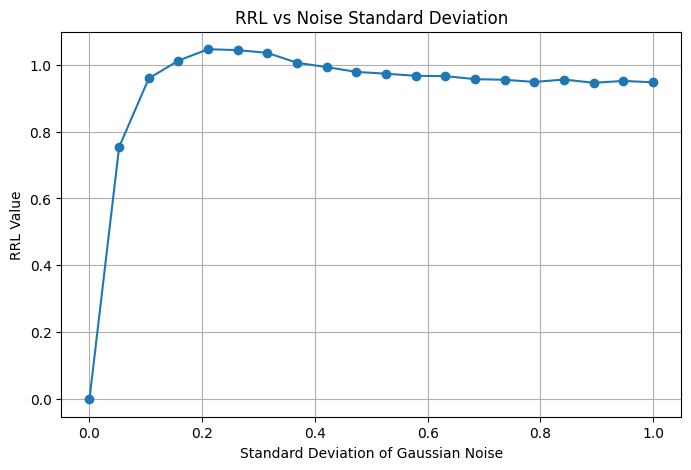

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have:
# y_pred_noisy_probs_list_1, y_pred_noisy_probs_list, y_reference_probs_list_1 (all lists of arrays of shape (samples, num_classes))
# and stddev_values (length 20)

rrl_values = []

for pred_noisy_1, pred_noisy, ref_probs in zip(y_pred_noisy_probs_list_1, y_pred_noisy_probs_list, y_reference_probs_list_1):
    # Compute numerator: l2 norm squared between pred_noisy_1 and ref_probs
    numerator = np.linalg.norm(pred_noisy_1 - ref_probs) ** 2

    # Compute denominator: l2 norm squared between pred_noisy and ref_probs
    denominator = np.linalg.norm(pred_noisy - ref_probs) ** 2

    # Compute RRL value
    rrl = numerator / denominator if denominator != 0 else np.nan
    rrl_values.append(rrl)

# Plot RRL vs Standard Deviation
plt.figure(figsize=(8, 5))
plt.plot(stddev_values, rrl_values, marker='o')
plt.xlabel('Standard Deviation of Gaussian Noise')
plt.ylabel('RRL Value')
plt.title('RRL vs Noise Standard Deviation')
plt.grid(True)
plt.show()


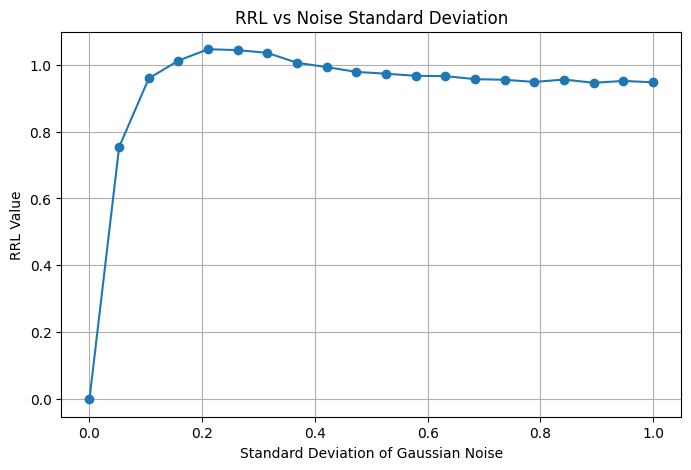

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have:
# y_pred_noisy_probs_list_1, y_pred_noisy_probs_list, y_reference_probs_list_1 (all lists of arrays of shape (samples, num_classes))
# and stddev_values (length 20)

rrl_values = []

for pred_noisy_1, pred_noisy, ref_probs in zip(y_pred_noisy_probs_list_1, y_pred_noisy_probs_list, y_reference_probs_list_1):
    # Compute numerator: l2 norm squared between pred_noisy_1 and ref_probs
    numerator = np.linalg.norm(pred_noisy_1 - ref_probs) ** 2

    # Compute denominator: l2 norm squared between pred_noisy and ref_probs
    denominator = np.linalg.norm(pred_noisy - ref_probs) ** 2

    # Compute RRL value
    rrl = numerator / denominator if denominator != 0 else np.nan
    rrl_values.append(rrl)

# Plot RRL vs Standard Deviation
fig = plt.figure(figsize=(8, 5))
plt.plot(stddev_values, rrl_values, marker='o')
plt.xlabel('Standard Deviation of Gaussian Noise')
plt.ylabel('RRL Value')
plt.title('RRL vs Noise Standard Deviation')
plt.grid(True)

# Save the figure as PDF before showing
fig.savefig('rrl_vs_noise_Eurosat.pdf')

# Show the plot
plt.show()
